# Plot boxplots of low/high frequency spectral power features

Plot the inter-event variation in low and high frequency band power for every subject at each recording day. This will generate Fig. 5 from the paper.

In [1]:
%matplotlib inline
import numpy as np
import pdb, sys, natsort
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

from tfr_utils import load_project_spectral_power

## Set parameters

In [2]:
tfr_lp = '.../data_release/naturalistic_reaches/tfr/'
roi_proj_loadpath = '.../data_release/roi_proj_matlab/'
n_subjs = 12

rem_bad_chans = True #don't use bad channels for ROI projection
elec_dens_thresh = 3 #threshold for dipole density

atlas = 'aal'
t_ave = [0, 0.5] # sec
f_ave_lo = [8,32] # Hz
f_ave_hi = [76,100] # Hz
n_freqs = 2

## Find regions of interest based on electrode density

In [3]:
#Load in electrode to ROI weight matrices
for s in range(n_subjs):
    df = pd.read_csv(roi_proj_loadpath+atlas+'_'+str(s+1).zfill(2)+'_elecs2ROI.csv')
    if s==0:
        elec_densities = df.iloc[0]
    else:
        elec_densities += df.iloc[0]
elec_densities = elec_densities/n_subjs 

#Select ROI's that have electrode density above threshold
good_rois = np.nonzero(np.asarray(elec_densities)>elec_dens_thresh)[0]
roi_labels = df.columns.tolist()
print('Selected '+str(len(good_rois))+' regions')

Selected 8 regions


## Create spectral power features

In [4]:
#Combine metadata and power across days
power_roi = load_project_spectral_power(tfr_lp,roi_proj_loadpath,good_rois,n_subjs,
                                        atlas=atlas,rem_bad_chans=rem_bad_chans)

#Crop power data and average across time bins
power_roi = power_roi.crop(tmin=t_ave[0],tmax=t_ave[1])
power_subj_t_ave = np.median(power_roi.data,axis=-1) #average across time bins

#Average over frequency bands
power_subj_t_ave_cp = power_subj_t_ave.copy()
power_subj_t_ave = power_subj_t_ave[...,:n_freqs] #only need n_freqs frequencies
f_inds_lo = np.nonzero(np.logical_and(power_roi.freqs>=f_ave_lo[0],power_roi.freqs<=f_ave_lo[1]))[0]
f_inds_hi = np.nonzero(np.logical_and(power_roi.freqs>=f_ave_hi[0],power_roi.freqs<=f_ave_hi[1]))[0]
power_subj_t_ave[...,0] = np.median(power_subj_t_ave_cp[...,f_inds_lo],axis=-1)
power_subj_t_ave[...,1] = np.median(power_subj_t_ave_cp[...,f_inds_hi],axis=-1)

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_3_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_4_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_5_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_3_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_4_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_5_l_allEpochs_tfr.h5 ...
Add

## Plot boxplots of power spread across events (separated by day)

<ipython-input-7-75f294ff57e1>:79: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax[i].transAxes)


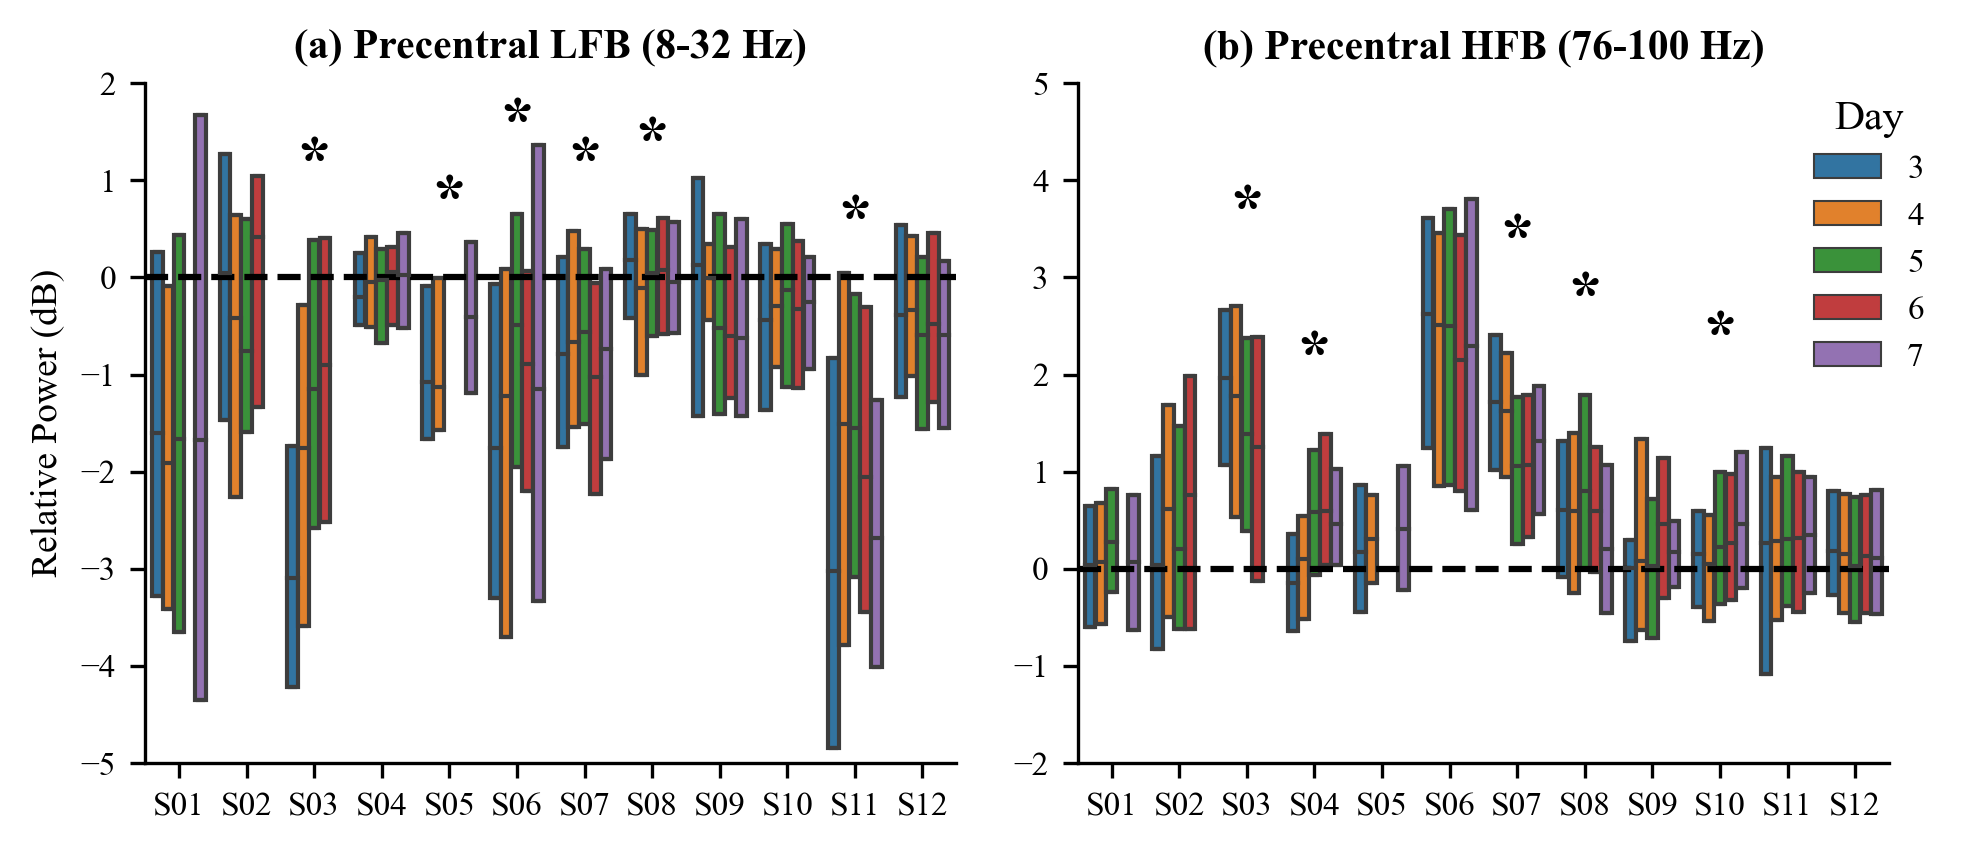

In [7]:
star_fontsize = 16
patients_unique_labels = power_roi.metadata['patient_id'].unique()
# print(patients_unique_labels)

roi_ind = 0 #0,2
hist_maxmin = 5
freq_band_labels = ['LFB (8-32 Hz)','HFB (76-100 Hz)']
freq_dict = {0:'low',1:'high'}

pow_dat_lst, freq_lst, subj, sbj_day = [],[],[], []
for freq_ind in range(n_freqs):
    for s,patID in enumerate(patients_unique_labels):
        pat_inds = np.nonzero(power_roi.metadata['patient_id'].values==patID)[0]
        # Iterate through all recording days for each participant
        days_unique = np.unique(power_roi.metadata['day'].values[pat_inds])
        days_unique = np.asarray(natsort.natsorted(days_unique))
        for day_curr in days_unique:
            day_inds = np.nonzero(power_roi.metadata['day'].values[pat_inds]==day_curr)[0]
            pow_dat_tmp = power_subj_t_ave[pat_inds[day_inds],roi_ind,freq_ind].tolist()
            pow_dat_lst.extend(pow_dat_tmp)
            freq_lst.extend([freq_dict[freq_ind]]*len(pow_dat_tmp))
            subj.extend(['S'+str(int(patID)+1).zfill(2)]*len(pow_dat_tmp))
            sbj_day.extend([day_curr]*len(pow_dat_tmp))
df_pat_sbj = pd.DataFrame(list(zip(pow_dat_lst,freq_lst,subj,sbj_day)),
                          columns=['Power','Frequencies','Subjects','Day'])

# Perform stats before plotting
sig_thresh = 0.05
sig_sbj, sig_day = [[],[]], [[],[]]
for i in range(n_freqs):  
    stats = pg.kruskal(data=df_pat_sbj.loc[df_pat_sbj['Frequencies']==freq_dict[i]],
                       dv='Power',between='Subjects')
    sig_val = 1 if float(stats['p-unc'])<sig_thresh else 0
    sig_sbj[i].append(sig_val)
    
sbjs_unique = np.unique(df_pat_sbj['Subjects'].values).tolist()
for i in range(n_freqs):
    df_freq_band = df_pat_sbj.loc[df_pat_sbj['Frequencies']==freq_dict[i]]
    for curr_sbj in sbjs_unique:
        stats = pg.kruskal(data=df_freq_band.loc[df_freq_band['Subjects']==curr_sbj],
                           dv='Power',between='Day')
        sig_val = 1 if float(stats['p-unc'])<sig_thresh else 0
        sig_day[i].append(sig_val)

# Plot results
fig,ax = plt.subplots(1,2,dpi=300,figsize=(7.5,3),gridspec_kw={'wspace':.15}) #,gridspec_kw={'hspace':.35})
pow_lims = [[-5,2],[-2,5]]
letters = ['(a) ','(b) ']
for i in range(n_freqs):
#     fig,ax = plt.subplots(1,1,dpi=300,figsize=(6,4)) #figsize=(24,4)
    sns.boxplot(data=df_pat_sbj.loc[df_pat_sbj['Frequencies']==freq_dict[i]],
                x='Subjects',y='Power',hue='Day',showfliers=False,whis=0,ax=ax[i],
                linewidth=1, hue_order=days_unique)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylim(pow_lims[i])
    ax[i].axhline(0,c='k',linestyle='--')
    ax[i].set_title(letters[i]+roi_labels[good_rois[roi_ind]][:-2]+' '+freq_band_labels[i],
                    fontweight='bold',fontsize=10)
    ax[i].get_legend().remove()
    ax[i].set_xlabel('',fontsize=9)
    if i==0:
        ax[i].set_ylabel('Relative Power (dB)',fontsize=9,fontweight='normal')
    else:
        ax[i].set_ylabel('')
    if i==0:
        xOffset = .2
    else:
        leg = ax[i].legend(loc='upper right',frameon=False, prop={'size': 8,'weight':'normal'},title='Day',fontsize=9)
        
        # Move legend over slightly
        bb = leg.get_bbox_to_anchor().inverse_transformed(ax[i].transAxes)
        yOffset, xOffset = 0.02, 0.08
        bb.y0 += yOffset
        bb.y1 += yOffset
        bb.x0 += xOffset
        bb.x1 += xOffset
        leg.set_bbox_to_anchor(bb, transform = ax[i].transAxes)
    
    # Add stats
    sig_inds = np.nonzero(sig_day[i])[0]
    star_y_vals = [1.5,1.5,1,1,.6,1.4,1,1.2,1.5,1.2,.4,1] if i==0 else [1.5,2.5,3.5,2,2,4.5,3.2,2.6,2.2,2.2,2.2,2.2]
    for ind in sig_inds.tolist():
        ax[i].text(ind,star_y_vals[ind],'*',fontsize=star_fontsize,fontweight='bold',ha='center')
    ax[i].tick_params(axis='both', labelsize=8)
    
# Save figure
dpi_plt = 300
fig_sp = '/data1/users/stepeter/mvmt_init/figs/'
fig_name = 'band_spec_days_sbjs'
# fig.savefig(fig_sp+fig_name+'.eps',
#             format='eps',  transparent= True,dpi=dpi_plt,
#             bbox_inches = 'tight', pad_inches = 0.01,
#             )

plt.show()

## Run stats across participants and across days for each participant

In [8]:
print('Across participants:')
for i in range(n_freqs):  
    stats = pg.kruskal(data=df_pat_sbj.loc[df_pat_sbj['Frequencies']==freq_dict[i]],
                       dv='Power',between='Subjects')
    print(freq_dict[i])
    print(stats['p-unc']) #round(float(stats['p-unc']),3))
    
print('Across days:')
sbjs_unique = np.unique(df_pat_sbj['Subjects'].values).tolist()
for i in range(n_freqs):
    print(freq_dict[i])
    df_freq_band = df_pat_sbj.loc[df_pat_sbj['Frequencies']==freq_dict[i]]
    for curr_sbj in sbjs_unique:
        stats = pg.kruskal(data=df_freq_band.loc[df_freq_band['Subjects']==curr_sbj],
                           dv='Power',between='Day')
        if float(stats['p-unc'])<0.05:
            print('Sbj '+curr_sbj)
            print(stats['p-unc']) #round(float(stats['p-unc']),3))

Across participants:
low
Kruskal    2.060650e-159
Name: p-unc, dtype: float64
high
Kruskal    2.439607e-278
Name: p-unc, dtype: float64
Across days:
low
Sbj S03
Kruskal    7.426142e-12
Name: p-unc, dtype: float64
Sbj S05
Kruskal    0.01274
Name: p-unc, dtype: float64
Sbj S06
Kruskal    0.0002
Name: p-unc, dtype: float64
Sbj S07
Kruskal    0.041141
Name: p-unc, dtype: float64
Sbj S08
Kruskal    0.013018
Name: p-unc, dtype: float64
Sbj S11
Kruskal    0.000003
Name: p-unc, dtype: float64
high
Sbj S03
Kruskal    0.002198
Name: p-unc, dtype: float64
Sbj S04
Kruskal    0.000017
Name: p-unc, dtype: float64
Sbj S07
Kruskal    0.000002
Name: p-unc, dtype: float64
Sbj S08
Kruskal    0.003944
Name: p-unc, dtype: float64
Sbj S10
Kruskal    0.006135
Name: p-unc, dtype: float64
